# ML 2: After Intro (Intro 2)

## Contents<a id="contents"></a>
* ["Data"](#data)
* [Overfitting](#overfitting)
* [KNN](#knn)
  * KNN Regression
  * "Handmade" Trainable KNN
  * Overfitting
  * "Handmade" Non-Trainable KNN
* [Scikit-learn (sklearn)](#sklearn)
  * "Imported" KNN
* [Validation](#validation)
  * X -> X_train + X_val
  * Grid Search for Finding Best $k$
  * "Semi-Handmade" Cross Validation for Finding Best $k$
  * More About Cross Validation in Scikit-learn

In [1]:
from numbers import Number
from typing import Callable, Union

try:
    from typing import Protocol
except ImportError:
    print('Python version is probably <3.8 ... Bye, Protocol.')

    Protocol = object

import numpy as np
import matplotlib.pyplot as plt
import tqdm
from numpy import array

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 26

## "Data"<a id="data"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [3]:
def a_true(x):
    if isinstance(x, list):
        x = np.array(x)

    return np.pi/2 * x ** 2

In [4]:
np.random.seed(942022)


total_num_points = 20
INTERVAL = list(range(-total_num_points//2, total_num_points//2))
test_size = 0.3
noise = 0.1
min_noise_std = 30


_X = np.array(INTERVAL)
_y = a_true(_X)
_y = _y + np.random.normal(
    0, np.max(
        np.vstack([noise * _y, min_noise_std * np.ones_like(_y)]),
        axis=0,
    )
)

_X = _X[:, np.newaxis]


training_set_indices = np.random.choice(
    list(range(len(_X))),
    size=int(total_num_points * (1.0 - test_size)),
    replace=False
)
test_set_indices = [i for i in list(range(len(_X))) if i not in training_set_indices]


X = _X[training_set_indices]
y = _y[training_set_indices]
X_test = _X[test_set_indices]
y_test = _y[test_set_indices]

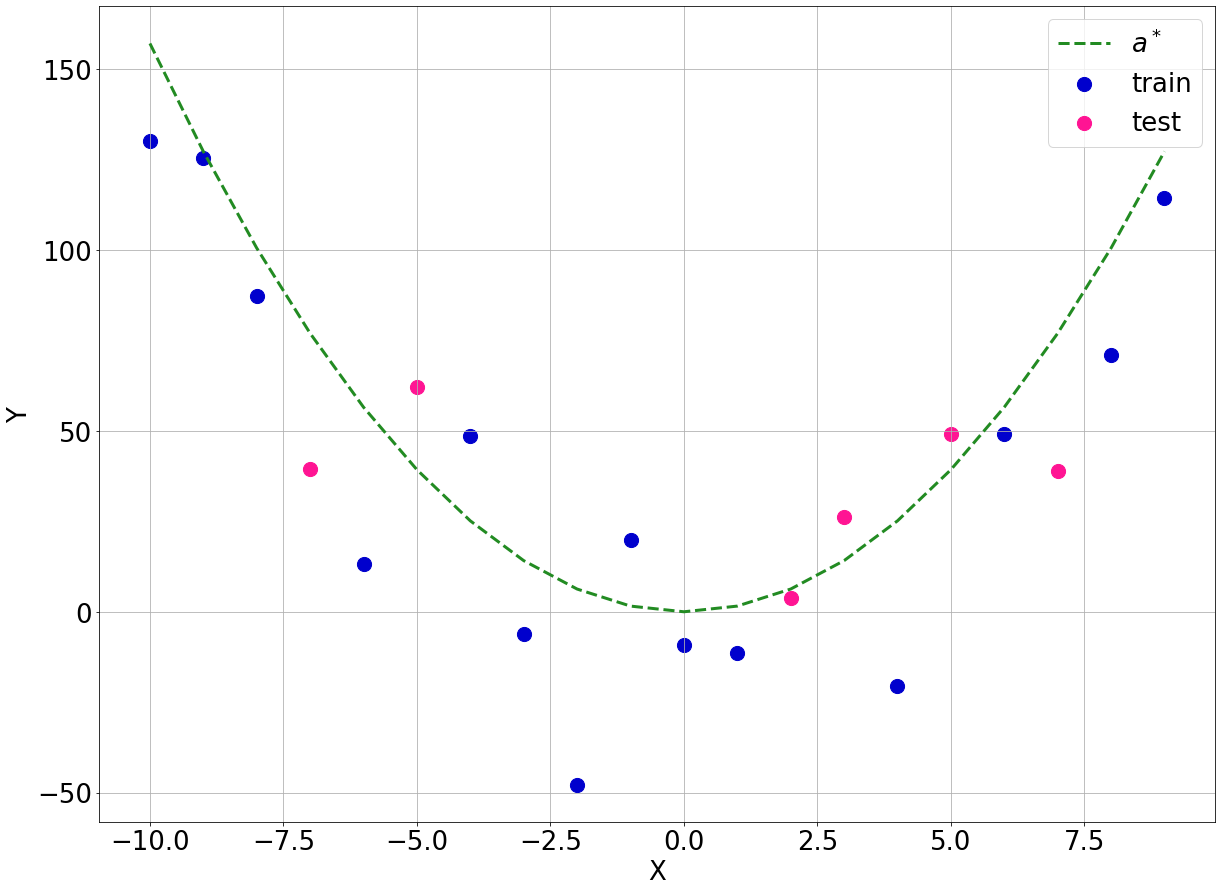

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))


plt.plot(
    INTERVAL, a_true(INTERVAL),
    color='forestgreen', linestyle='--', linewidth=3,
    label=r'$a^*$'
)
plt.scatter(X, y, s=200, label='train', color='mediumblue')
plt.scatter(X_test, y_test, s=200, label='test', color='deeppink')


plt.grid()

plt.xlabel('X')
plt.ylabel('Y')

plt.legend()

plt.show()

In [6]:
class Predictor(Protocol):
    def predict(self, x: array) -> array:
        raise NotImplementedError()

In [7]:
def plot(model: Union[Callable, Predictor], label: str):
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))


    plt.plot(
        INTERVAL, a_true(INTERVAL),
        color='forestgreen', linestyle='--', linewidth=3,
        label=r'$a^*$'
    )
    plt.scatter(X, y, s=200, label='train', color='mediumblue')
    plt.scatter(X_test, y_test, s=200, label='test', color='deeppink')
    
    if callable(model):
        prediction = model(INTERVAL)
    else:
        prediction = model.predict(_X)
    
    plt.plot(
        INTERVAL, prediction,
        color='darkorange', linewidth=3, label=label
    )

    plt.grid()

    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    
    plt.show()
    

def test(model: Union[Callable, Predictor]) -> str:
    if callable(model):
        prediction = model(X_test)
    else:
        prediction = model.predict(X_test)

    difference = np.mean(np.abs(prediction - y_test))
    
    return difference

In [8]:
TEST_MESSAGE_TEMPLATE = 'Average abs difference (test): {difference:.2f}.'

## Overfitting<a id="overfitting"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

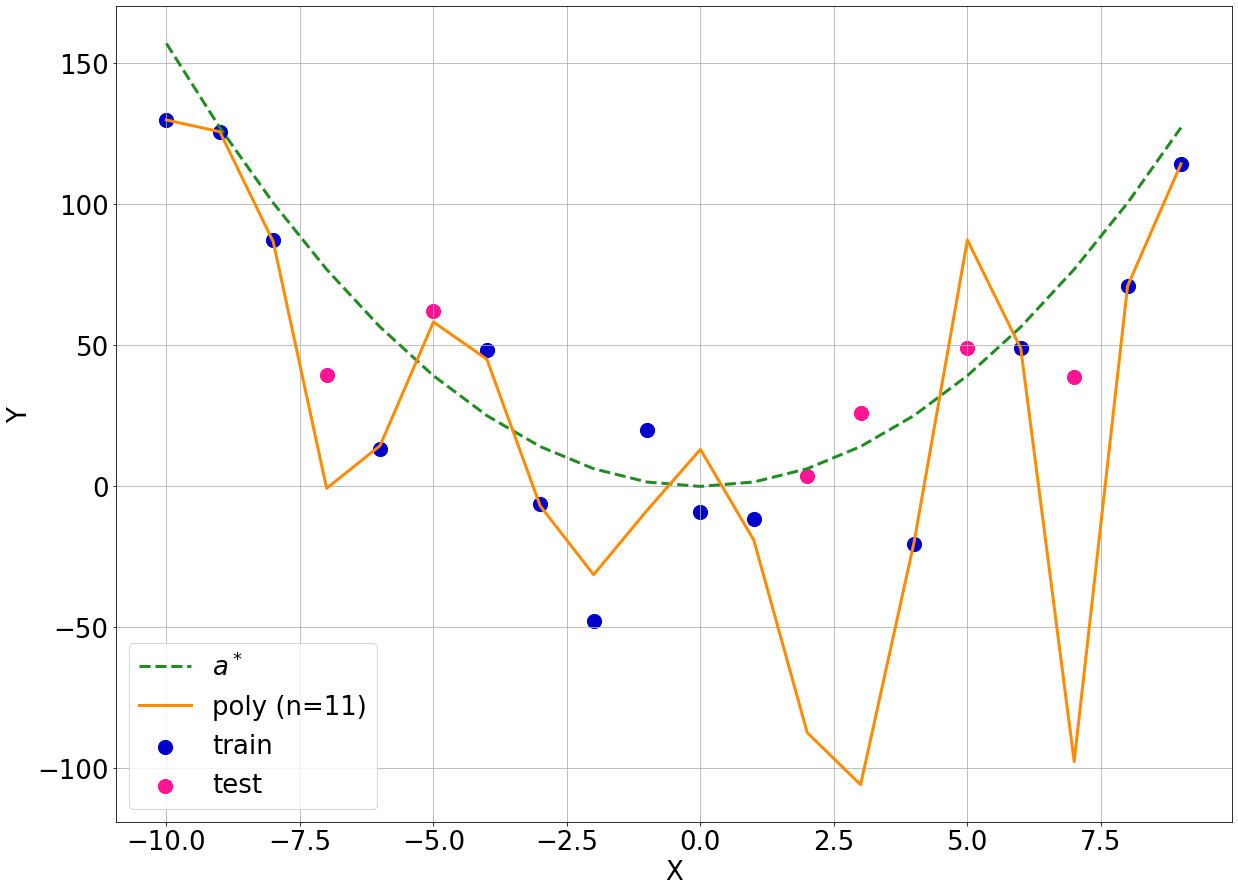

Average abs difference (test): 85.24.


In [9]:
n = 11
coeffs = np.polyfit(X.flatten(), y, n)
poly = np.poly1d(coeffs)

plot(poly, label=f'poly (n={n})')
test_value = test(poly)

print(TEST_MESSAGE_TEMPLATE.format(difference=test_value))

del poly

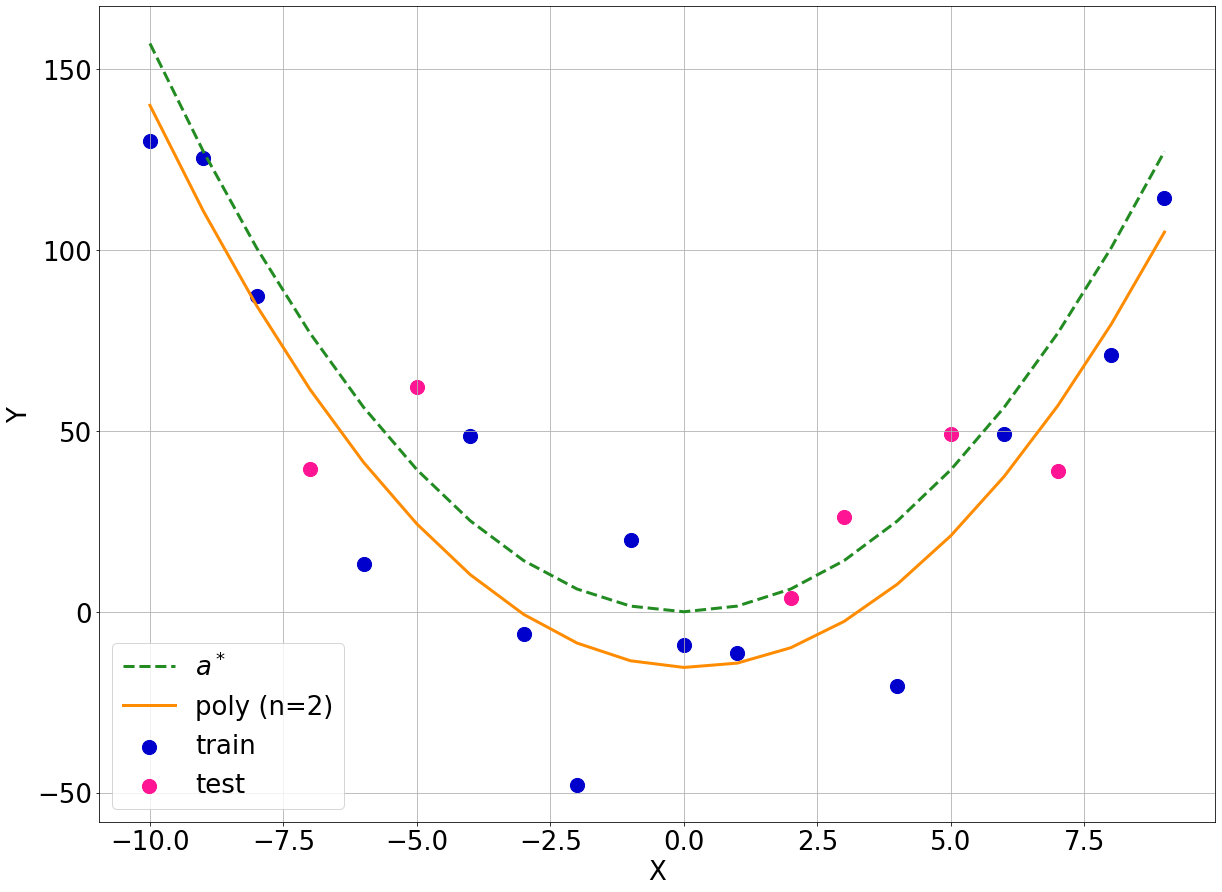

Average abs difference (test): 28.91.


In [10]:
n = 2
coeffs = np.polyfit(X.flatten(), y, n)
poly = np.poly1d(coeffs)

plot(poly, label=f'poly (n={n})')
test_value = test(poly)

print(TEST_MESSAGE_TEMPLATE.format(difference=test_value))

del poly

## KNN<a id="knn"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

k-Nearest Neighbours Algorithm.

<br>

<a href="https://vk.com/wall-35595350_1388258">
    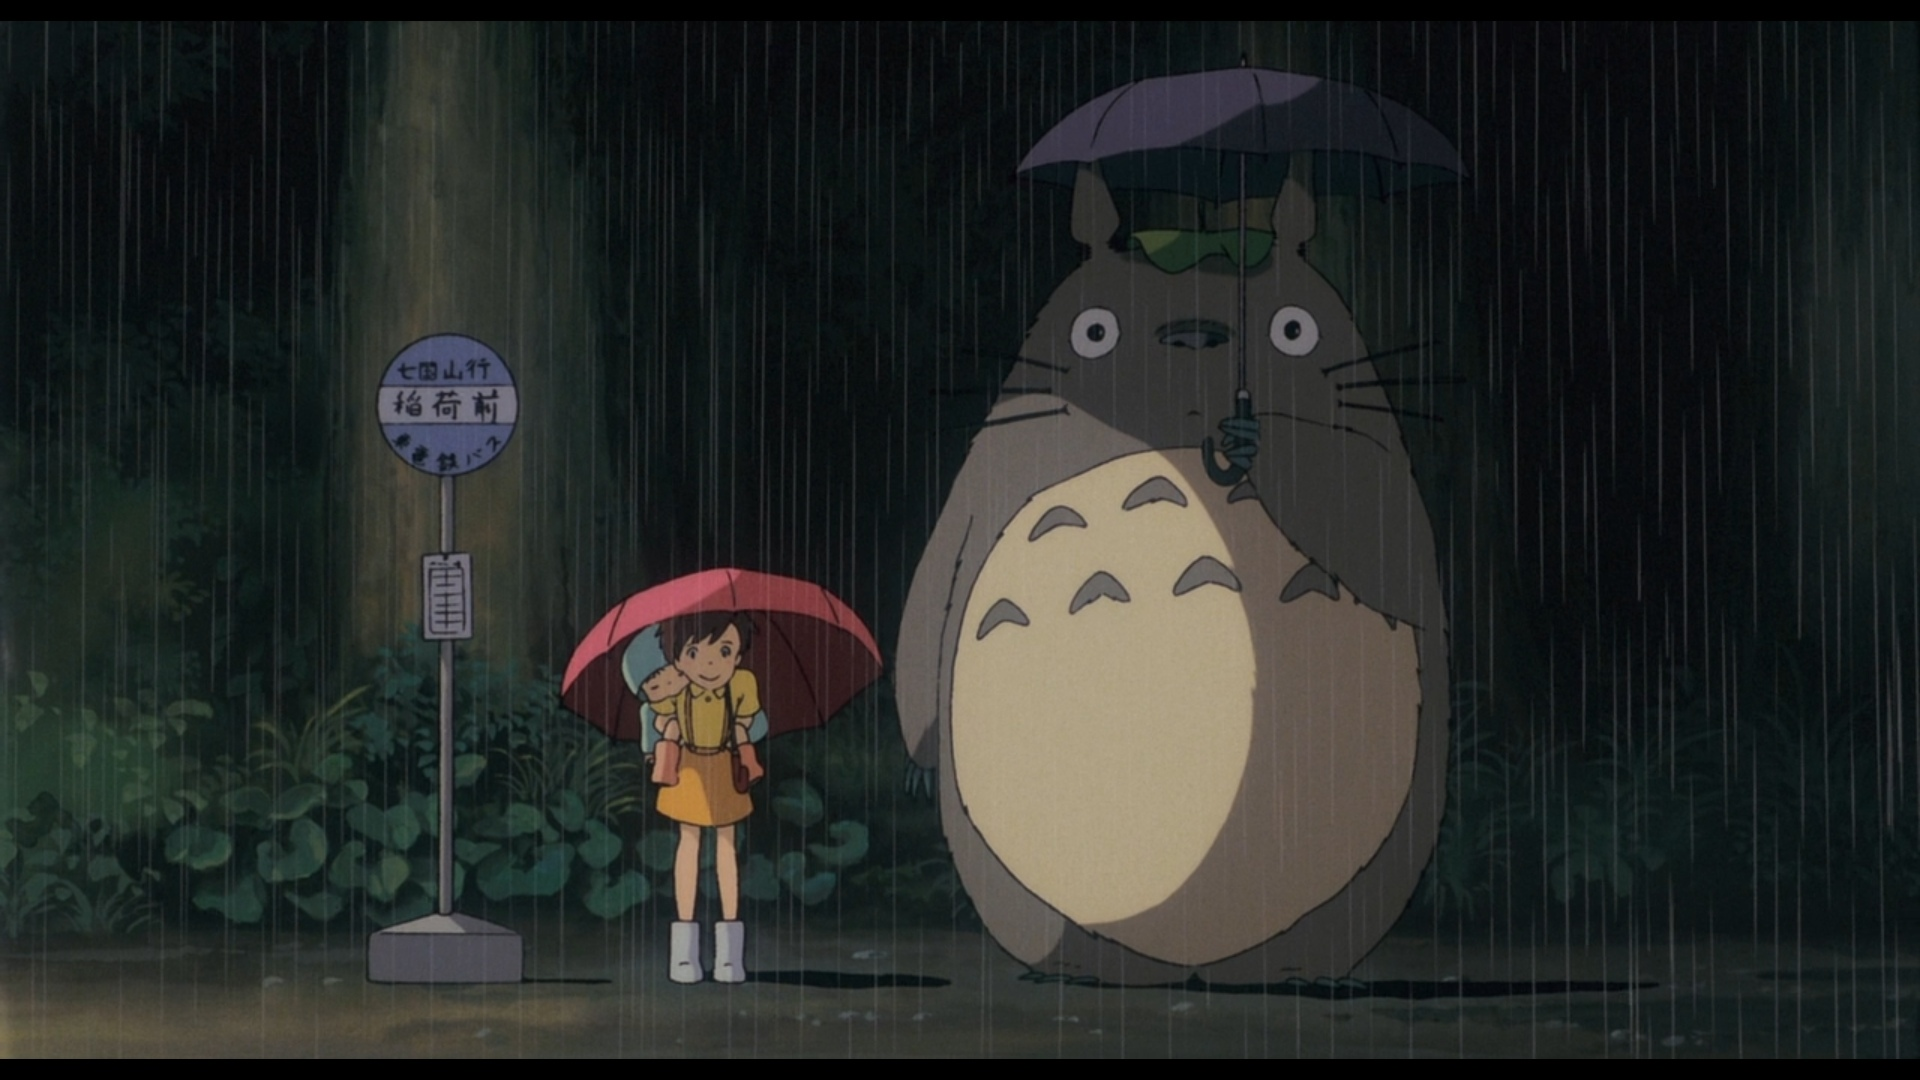
</a>

### KNN Regression


#### Problem Formulation

Обучающая выборка (объекты, для которых знаем ответы $a^*(x) = y_{true}(x)$):

$$ X_l = \{x_i, y_i\}_{i=1}^l $$

В регрессии: $y_i \in \mathbb R$.

Ответ для нового объекта $x$ получаем, глядя на *ближайших соседей* объекта $x$ из обучающей выборки $X^l$.
Предсказание $a(x) = y_{pred}$ считаем как взвешенную сумму ответов для соседей, с весом тем меньшим, чем меньше сосед похож на рассматриваемый объект $x$:

$$ y_{pred} \equiv \sum_{j_x = 1}^k w_{j_x} y_{j_x}$$

где сумма берётся по $k$ ближайшим соседям объекта $x$ (что отражено как индекс $x$ у индекса суммы $j$; далее для простоты будем без двухуровнего индекса).

*В приведённой постановке* метод KNN зависит от выбора:
* числа соседей $k$,
* весов $(w_1, \ldots, w_k)$, определяющих вклад соседей в предсказание.

Количество соседей $k$ можно выбирать по качеству на отложенной выборке.
Веса же надо обучить...

На самом деле KNN определяется ещё способом оценки расстояния между объектами $\rho(\cdot, \cdot)$.
В нашем случае объекты — это просто числа, поэтому вопрос с $\rho$ особой роли не играет.
Также важен способ получения ответа для данного объекта по ответам для соседей.
Мы рассматриваем способ, основанный на вычислении взвешенной суммы.


#### Training

Выведем формулу оновления весов для обучения методом градиентного спуска.
Определим дифференцируемую потерю (loss) при предсказании ответа для одного объекта из обучающей выборки:
$$
  l(x) = (a(x) - a^*(x))^2 = (y_{pred}(x) - y_{true}(x))^2
$$

Тогда суммарная потеря на всей обучающей выборке:
$$
  L(X^l) = \sum_{i = i}^l (y_{pred}(x_i) - y_{true}(x_i))^2
         = \sum_{i = i}^l \left(\sum_{j = 1}^k w_{j} y_{j} - y_{true}(x_i)\right)^2
$$

Производная $L$ по $w_r, 1 \leqslant r \leqslant k$:
$$
  \frac{\partial L}{\partial w_r}
      = 2 \cdot \sum_{i = i}^l \left(\sum_{j = 1}^k w_{j} y_{j} - y_{true}(x_i)\right) y_r
$$

Если обозначить за $\nabla L$ градиент суммарной потери по вектору весов $\boldsymbol w = (w_1, \ldots, w_k)$:
$$
  \nabla L(\boldsymbol w) = \left(
      \frac{\partial L}{\partial w_1}, \ldots, \frac{\partial L}{\partial w_k}
  \right)
$$
то формулу обновления весов можно записать как
$$
  \boldsymbol w_{i+1} = \boldsymbol w_{i} - \gamma \nabla L(\boldsymbol w_{i})
$$
где $\gamma \in \mathbb R$ — шаг градиентного спуска (learning rate).

### "Handmade" Trainable KNN

In [11]:
class KNN:
    def __init__(
            self,
            num_neighbours: int,
            start_lr: float,
            num_iters: int,
            schedule: bool = True
            ):
        self._X = None
        self._y = None

        self._num_neighbours = num_neighbours
        self._weights = np.ones(shape=(self._num_neighbours,))
        
        self._start_lr = start_lr
        self._num_iters = num_iters
        self._schedule = schedule
        
        self._training = True
    
    def __call__(self, input):
        if isinstance(input, Number):
            input = [input]

        predictions = list()
        
        for x in input:
            argsort = np.argsort(np.abs(x - self._X).flatten())

            if self._training:
                neighbours = argsort[1:1+self._num_neighbours]
            else:
                neighbours = argsort[:self._num_neighbours]

            neighbour_answers = self._y[neighbours]
            prediction = np.sum(self._weights * neighbour_answers)
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def fit(self, X: array, y: array) -> None:
        # TODO: find neighbours only once for training
        self._X = X
        self._y = y

        with tqdm.tqdm(total=self._num_iters) as pbar:
            for current_iteration in range(self._num_iters):
                loss = self._loss()
                grad_loss = self._grad_loss()

                if self._schedule:
                    current_step = 1 / 2 * self._start_lr * (
                        1 + np.cos(current_iteration / self._num_iters) * np.pi
                    )
                else:
                    current_step = starting_step

                self._weights = self._weights - current_step * grad_loss

                pbar.set_description(f'Loss: {loss:.2f}.')
                pbar.update(1)

    def predict(self, input: array) -> array:
        return self(input)
    
    def eval(self):
        self._training = False
    
    def _loss(self):
        prediction = self(self._X)
        
        return np.sum((prediction - self._y) ** 2)
    
    def _grad_loss(self):
        result = [0.0 for _ in range(self._num_neighbours)]
        
        for x, y_true in zip(self._X, self._y):
            # TODO: copy-pasted from predict
            argsort = np.argsort(np.abs(x - self._X).flatten())

            if self._training:
                neighbours = argsort[1:1+self._num_neighbours]
            else:
                neighbours = argsort[:self._num_neighbours]

            neighbour_answers = self._y[neighbours]
            prediction = np.sum(self._weights * neighbour_answers)
            
            for i in range(self._num_neighbours):
                result[i] = result[i] + 2 * (prediction - y_true) * neighbour_answers[i]
        
        for i in range(self._num_neighbours):
            result[i] = result[i] / len(self._X)

        return np.array(result)

In [12]:
knn = KNN(num_neighbours=3, start_lr=0.000001, num_iters=2000)

In [13]:
knn.fit(X, y)

Loss: 16622.70.: 100%|█████████████████████████| 2000/2000 [00:03<00:00, 503.43it/s]


In [14]:
knn._weights

array([0.48983299, 0.54596873, 0.10659681])

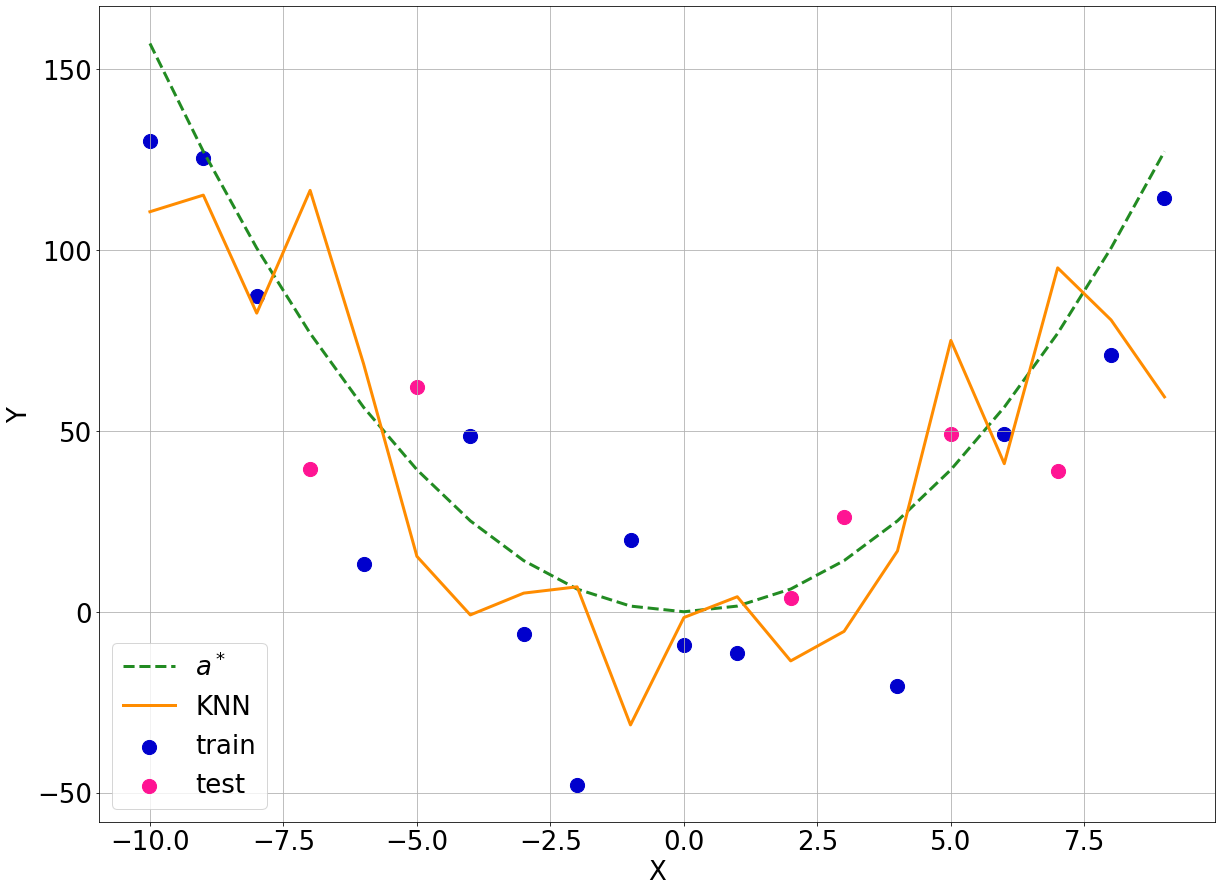

Average abs difference (test): 42.45.


In [15]:
plot(knn, label='KNN')
test_value = test(knn)

print(TEST_MESSAGE_TEMPLATE.format(difference=test_value))

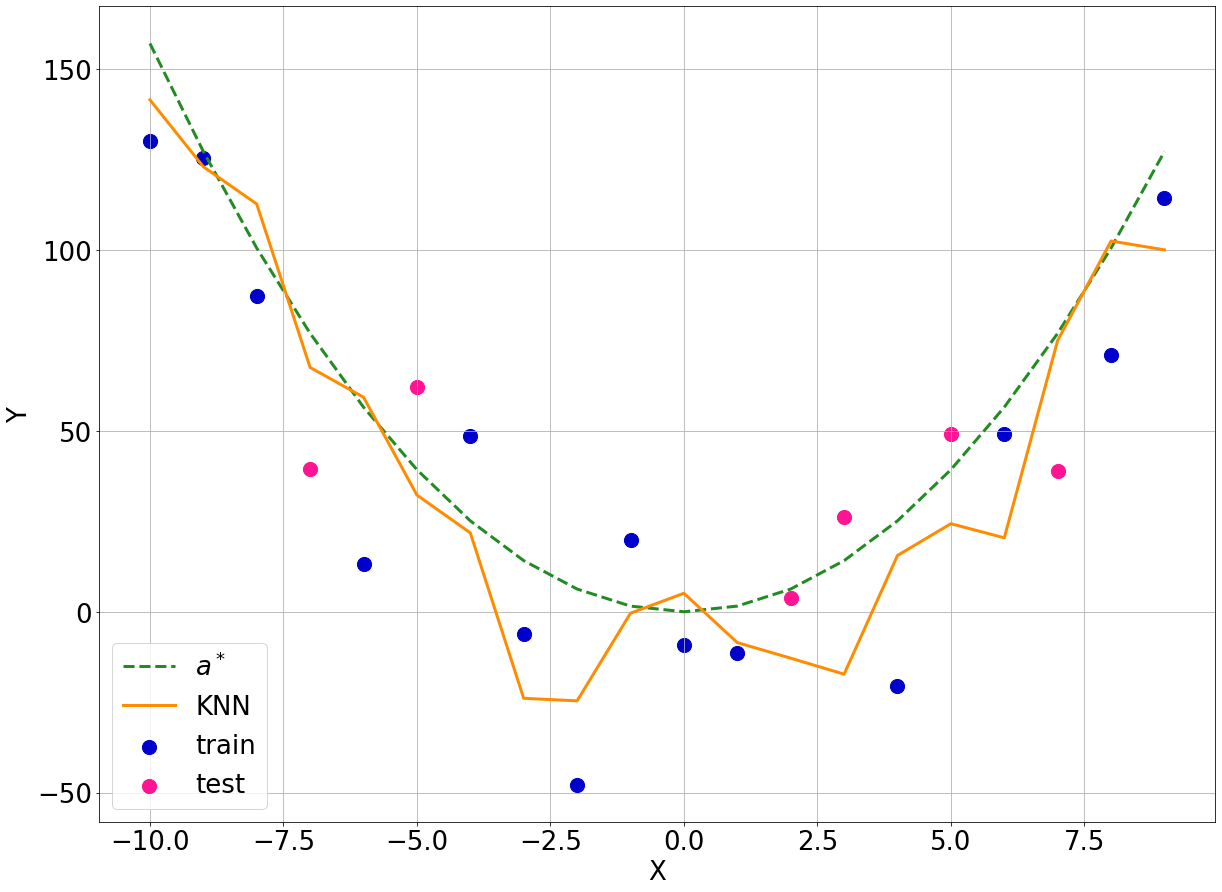

Average abs difference (test): 29.77.


In [16]:
knn.eval()

plot(knn, label='KNN')
test_value = test(knn)

print(TEST_MESSAGE_TEMPLATE.format(difference=test_value))

### Overfitting

In [17]:
knn = KNN(num_neighbours=3, start_lr=0.000001, num_iters=2000)
knn.eval()

knn.fit(X, y)

Loss: 0.22.: 100%|█████████████████████████████| 2000/2000 [00:03<00:00, 508.91it/s]


In [18]:
print(knn._weights)

[0.99658901 0.00158961 0.00264835]


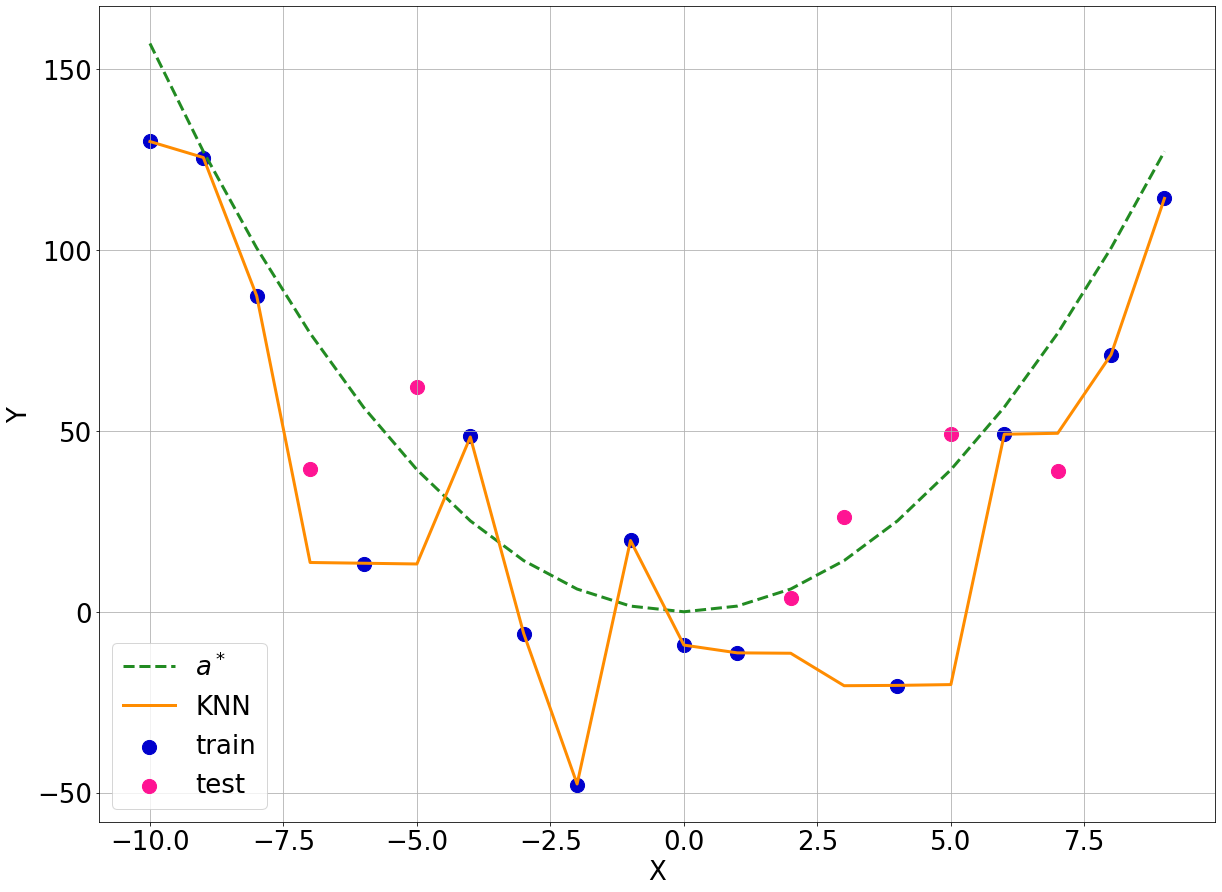

Average abs difference (test): 36.06.


In [19]:
plot(knn, label='KNN')
test_value = test(knn)

print(TEST_MESSAGE_TEMPLATE.format(difference=test_value))

### "Handmade" Non-Trainable KNN

Кажется разумным предположение, что "важность" соседа в смысле вклада в предсказание должна быть тем меньше, чем менее сосед похож на итрересующий нас в данный момент объект.
Поэтому можно бы было просто считать вес $j$-го соседа $x_j$ объекта $x$ обратно пропорциональным расстоянию от него до этого соседа:
$$
  w_j = 1\, /\, \rho(x, x_j)
$$
Таким образом, веса $(w_1, \ldots, w_k)$ рассчитывались бы для каждого отдельного объекта $x$ в момент предсказания.

In [20]:
class KNN2:
    def __init__(
            self,
            num_neighbours: int,
            ):
        self._X = None
        self._y = None

        self._num_neighbours = num_neighbours

    
    def __call__(self, input):
        if isinstance(input, Number):
            input = [input]

        predictions = list()
        
        for x in input:
            distances = np.abs(x - self._X).flatten()
            argsort = np.argsort(distances)

            if distances[argsort[0]] == 0:
                prediction = self._y[argsort[0]]
            else:
                neighbours = argsort[:self._num_neighbours]
                neighbour_answers = self._y[neighbours]
                neighbour_distances = distances[neighbours]
                weights = 1.0 / neighbour_distances
                prediction = np.sum(
                    weights * neighbour_answers
                ) / np.sum(weights)
            
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def fit(self, X: array, y: array) -> None:
        self._X = X
        self._y = y

    def predict(self, input: array) -> array:
        return self(input)

In [21]:
knn = KNN2(num_neighbours=3)

In [22]:
knn.fit(X, y)

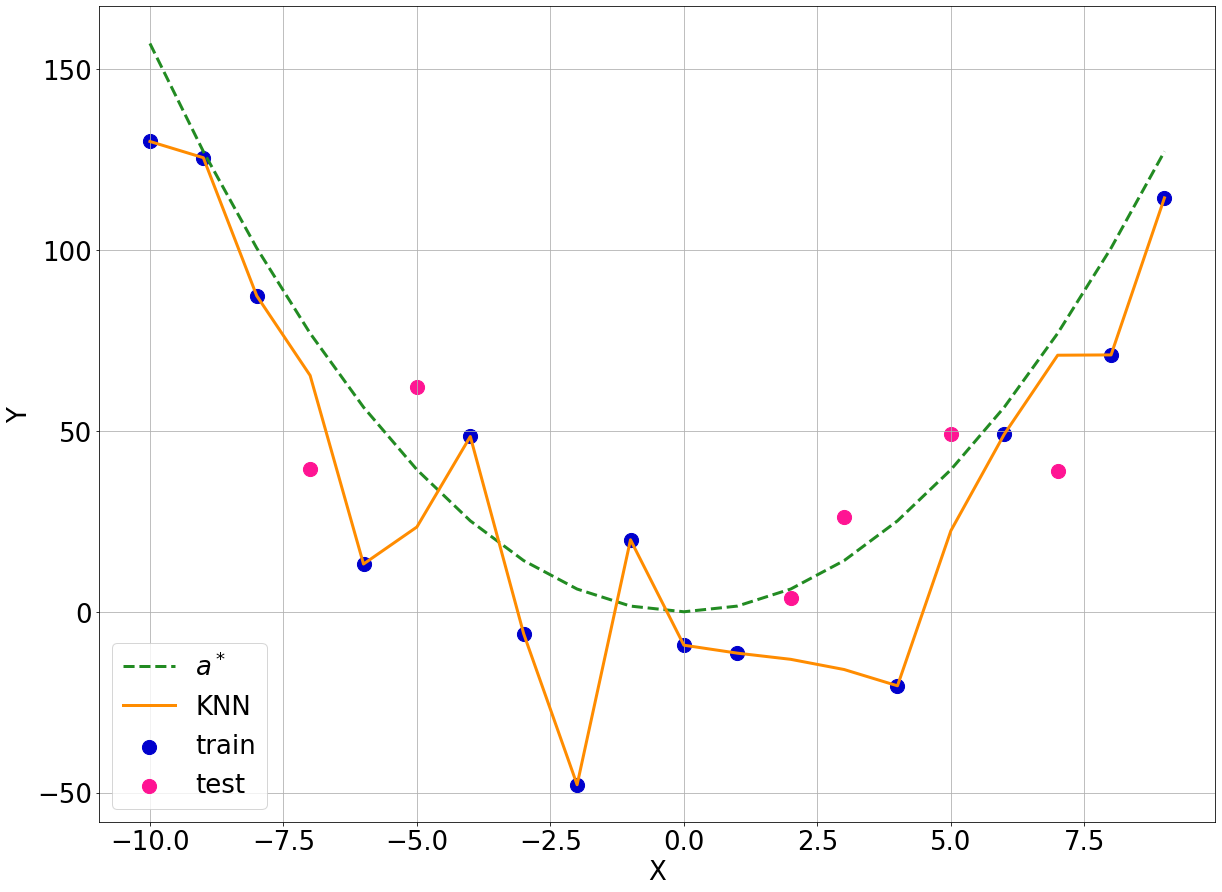

Average abs difference (test): 30.35.


In [23]:
plot(knn, label='KNN')
test_value = test(knn)

print(TEST_MESSAGE_TEMPLATE.format(difference=test_value))

## Scikit-learn (sklearn)<a id="sklearn"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

### "Imported" KNN

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [25]:
knn = KNeighborsRegressor(n_neighbors=3)

In [26]:
knn.fit(X, y)

KNeighborsRegressor(n_neighbors=3)

In [27]:
knn.predict([[2]])

array([-13.71014531])

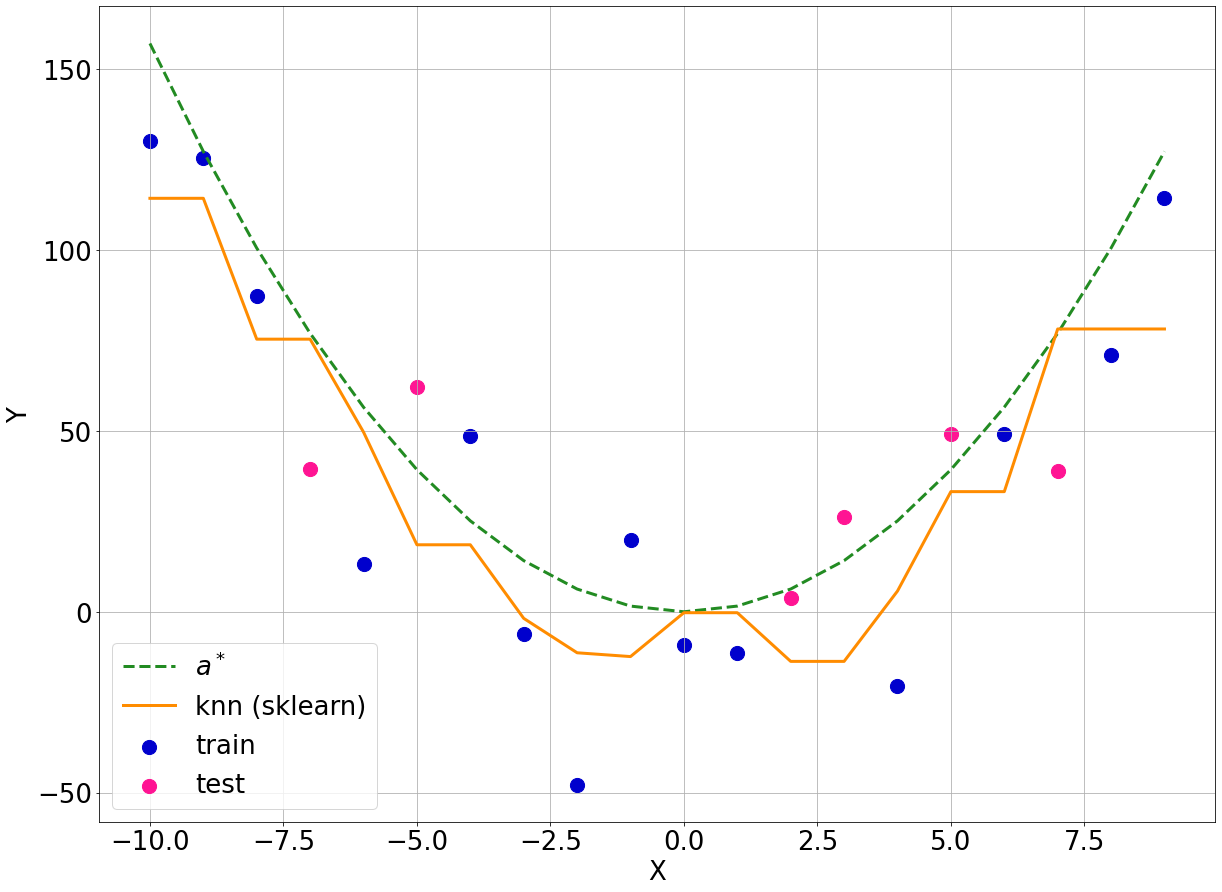

Average abs difference (test): 31.98.


In [28]:
plot(knn, label='knn (sklearn)')
test_value = test(knn)

print(TEST_MESSAGE_TEMPLATE.format(difference=test_value))

## Validation<a id="validation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

For quality assessment, and for parameter selection.

In [29]:
def valid(model: Union[Callable, Predictor], X, y):
    if callable(model):
        prediction = model(X)
    else:
        prediction = model.predict(X)

    difference = np.mean(np.abs(prediction - y))
    
    return difference

### X -> X_train + X_val

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=42
)

### Grid Search for Finding Best $k$

In [31]:
k2loss = dict()
k_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for k in k_grid:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    k2loss[k] = valid(knn, X_val, y_val)

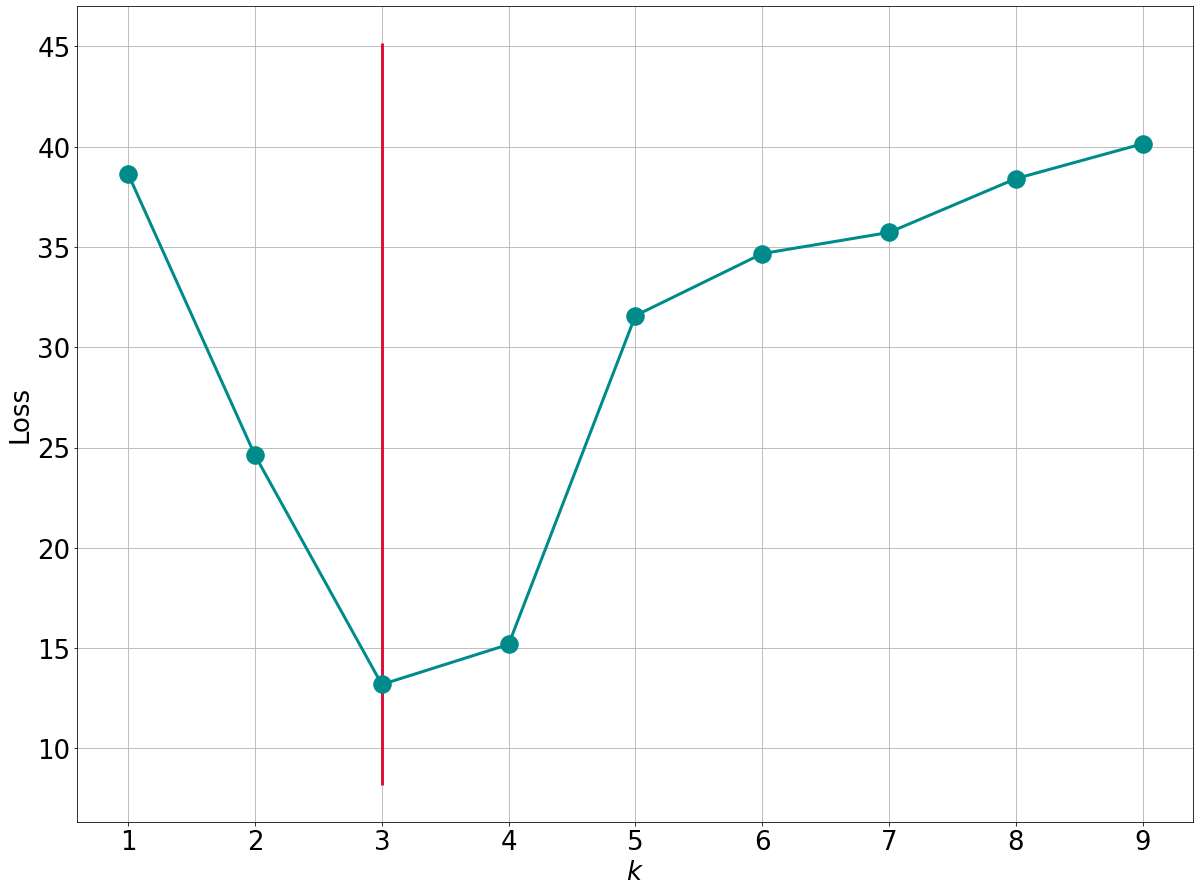

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))


_x = list(k2loss.keys())
_y = list(k2loss.values())

plt.plot(
    _x, _y,
    linewidth=3, marker='.', markersize=35,
    color='darkcyan'
)

best_k = _x[np.argmin(_y)]
gap = 5

plt.vlines(
    best_k, ymin=min(_y) - gap, ymax=max(_y) + gap,
    linewidth=3, color='crimson'
)

plt.xlabel(r'$k$')
plt.ylabel('Loss')

plt.grid()
plt.show()


del _x, _y

### "Semi-Handmade" Cross Validation for Finding Best $k$

In [33]:
num_splits = 3
k_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9]
k2losses = list()


for split in range(num_splits):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.30, random_state=split
    )
    
    _k2loss = dict()

    for k in k_grid:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)

        _k2loss[k] = valid(knn, X_val, y_val)
    
    k2losses.append(_k2loss)

In [34]:
k2losses

[{1: 43.8063401043535,
  2: 35.705516949677815,
  3: 36.909052138078245,
  4: 45.06550566755588,
  5: 50.17823741968569,
  6: 52.297891054751645,
  7: 55.91817904283619,
  8: 58.67882110192504,
  9: 63.70309782044321},
 {1: 26.67520707284799,
  2: 35.156125993889034,
  3: 55.56996466471753,
  4: 57.88718656304344,
  5: 64.81989667771519,
  6: 62.57487500149076,
  7: 64.07499190059448,
  8: 59.86558710658694,
  9: 55.123116008833165},
 {1: 40.09934703245231,
  2: 35.95269730694393,
  3: 34.27157618558361,
  4: 27.646513740252157,
  5: 35.170726926847735,
  6: 39.303887399942965,
  7: 33.023833484458976,
  8: 33.25879925330994,
  9: 34.67798827090006}]

In [35]:
k2loss = dict()
k2std = dict()

for k in k2losses[0]:
    if k not in k2loss:
        k2loss[k] = 0
    
    k2loss[k] = np.mean(
        [_k2l[k] for _k2l in k2losses]
    )
    k2std[k] = np.std(
        [_k2l[k] for _k2l in k2losses]
    )

In [36]:
k2loss

{1: 36.8602980698846,
 2: 35.60478008350359,
 3: 42.25019766279313,
 4: 43.53306865695049,
 5: 50.05628700808287,
 6: 51.392217818728454,
 7: 51.00566814262988,
 8: 50.60106915394064,
 9: 51.168067366725474}

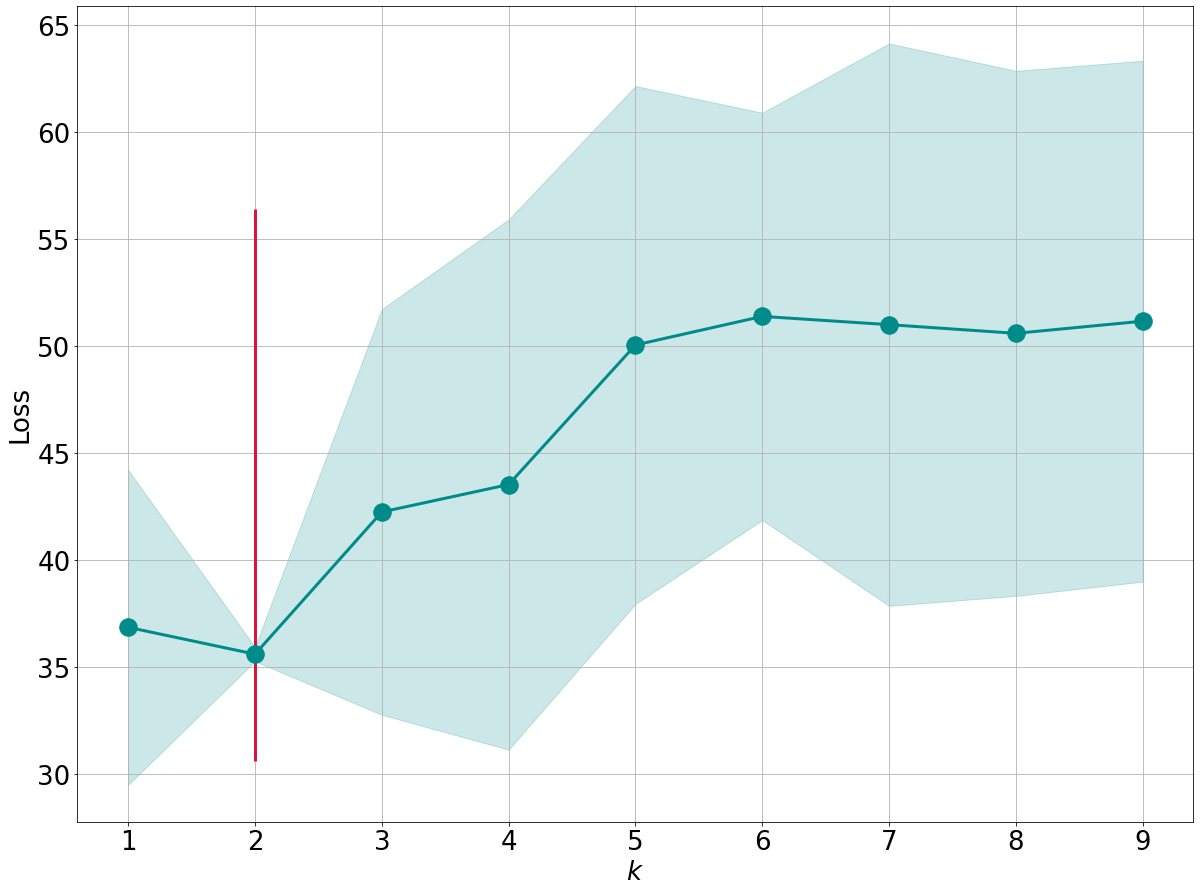

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))


_x = np.array(list(k2loss.keys()))
_y = np.array([k2loss[k] for k in _x])
_std = np.array([k2std[k] for k in _x])

plt.plot(
    _x, _y,
    linewidth=3, marker='.', markersize=35,
    color='darkcyan'
)

plt.fill_between(
    _x, _y + _std, _y - _std,
    color='darkcyan', alpha=0.2
)

best_k = _x[np.argmin(_y)]
gap = 5

plt.vlines(
    best_k, ymin=min(_y) - gap, ymax=max(_y) + gap,
    linewidth=3, color='crimson'
)

plt.xlabel(r'$k$')
plt.ylabel('Loss')

plt.grid()
plt.show()


del _x, _y

### More About Cross Validation in Scikit-learn

* [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)
* [GridSearchCV: cross-validated grid-search over a parameter grid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## P.S.

* [List of named Matplotlib colors](https://matplotlib.org/3.5.0/gallery/color/named_colors.html)